<h1>Fitter:  Polynomial Approximation in a Chebyshev Basis</h1><br>

<!-- <i>Justin E. Elenewski (MIT-LL)</i> <b>:</b> <i>Revision 02/14/2023</i> -->
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

<h2><u>1. Overview</u></h2>

Polynomial approximation and phase angle generation are accomplished using the `Angler` and `Fitter` modules  (respectively).  We will generically focus on representing a function $f: I \longrightarrow I $ that is both supported and bounded on  the extended unit interval $I = [-1, 1] \subset \mathbb{R}$. Given this specification, our  toolchain generates phase angles that implement a polynomial approximation $\pi(x)$ using QSP/QSVT while providing a uniformly bounded error $\epsilon_0$ over $I$.  While `Fitter` and `Angler` are used in tandem, we describe these components separately since the `Angler` may also use analytically defined polynomial approximations as input (via `Expander` module). 

This notebook outlines the use of `Fitter`.



<h2><u>2. Technical Details</u></h2>

<h3>2.1. Introduction & Inputs</h3>

`Fitter` uses a  Remez multiple-exhange algorithm to find the best degree-$d$  polynomial approximation $\pi_d$ to an arbitrary function $f$ (with some conditions stated below).   This section describes how we have implemented the Remez algorithm, with an emphasis on the nuances that are required by QSP/QSVT.

Our methods require four pieces of input:

1. <i><b>Target Function.</b></i> We assume that the target function $ f: I \longrightarrow I' $ is supported on, and bounded by, subsets of the extended unit interval $ I, I'  \subseteq [-1,1] \subset \mathbb{R}$.  This  ensures compatibility with QSP/QSVT and the associated phase angle generation routines (it is not a requirement of Remez algorithms in general).

2. <i><b>Parity.</b></i> The parity of the target function must be specified: even $f(x) = f(-x)$, odd $f(x) = -f(-x)$, or otherwise.

3. <i><b>Fitting Domain.</b></i> It is necessary to specify the domain on which $f$ is to be fit, and to provide an initial guess for the roots for the polynomial. A judicious selection of these parameters can markedly improve our approximations and drive faster calculations.  For instance, the function $f(x) = 1/(\kappa\cdot x)$ has a singularity as $x \longrightarrow 0$, making it difficult to fit at finite order.  By specifying a domain $I = [1/\kappa, 1]$ and taking advantage of parity constraints, we can apply Remez exchange on $I$ alone while giving an output polynomial $\pi_d$ that is supported on $[-1, -1/\kappa] \cup [1/\kappa, 1]$.  It is generally safe to use Chebyshev roots as an initial point set on the domain, since we use a Chebyshev basis to represent $\pi_d$ (as discussed below). 

4. <i><b>Polynomial Degree.</b></i> The degree $d$ of the best approximating polynomial $\pi_d$ will determine the accuracy of the approximation.  While increasing $d$ will generically give a lower error, this relationship also depends on $f$ and the interval on which it is approximated. 
<br>
    
<font size="5">⚠️</font>  <b>ATTENTION:</b> The remainder of this section can get quite technical, and these details are not required for use of the fitting methods (though understanding them can be <i>very</i> helpful when encountering difficulties). It possible to skip this part and move ahead to the numerical examples, particularly on first use.




<h3>2.2. Algorithmic Details</h3>

<h3>2.1.1 (a). Formalities: The <b>B</b>est <b>A</b>pproximating <b>P</b>olynomial (<b>BAP</b>)</h3>
 
The best approximating polynomial $\pi_d$ is defined according the <i>Minimax approximation</i>.  Stated succinctly, if $f$ is a complex-valued function on some interval $[a,b]$,  there exists a sequence of polynomials $p_n$ that converge uniformly,
    
\begin{equation}
\lim_{n\rightarrow \infty} p_n(x) = f(x),
\end{equation}

on this domain (this is an immediate corrolary of the Stone-Weierstrass theorem).  Using this result, we can  define $\pi_d$ as the polynomial of degree $d$ that is closest to $f$ in terms of the $L^\infty$ norm.  That is, 
    
\begin{split}
\epsilon &= \max_{x \in [a,b]} \vert f(x) - \pi_d(x) \vert     \\
    &= \vert \vert f(x) - \pi_d(x)\vert \vert_\infty 
\end{split}
    
where the second line defines the $L^\infty$ norm on $[a,b]$. Here,  $\epsilon = \epsilon_0 + \epsilon_1$ is an error measure with components that arise from the best possible approximation in our polynomial function space ($\epsilon_0$) and from numerical factors associated with the target algorithm ($\epsilon_1$).  Stated another way, the error bound $\epsilon_0$ is intrinsic to a a polynomial $\pi_d$ of fixed degree - we must increase $d$ to get a better approximation.
    
<br>
    
These formal considerations are of limited computational utility:  we still need a mechanism to determine if an arbitrary polynomial $p_d(x)$ corresponds to the best approximation $\pi_d(x)$.  The Chebyshev oscillation theorem gives a sufficiency condition for this, stating that $p_d(x) = \pi_d(x)$  if and only if there are at least $d+2$ points on $[a,b]$ where the error achieves its absolute maximum with alternating sign.  If we chose a set of points $a \leq x_0, x_1, \dots, x_{d+1} \leq b$, this can be written formally as,
    
\begin{split}
f(x_i) - \pi_d(x_i) &= \pm (-1)^i \, \max_{x \in [a,b]} \vert f(x) - \pi_d(x)\vert \\
    &= \pm (-1)^i \, \vert \vert f(x) - \pi_d(x)\vert \vert_\infty.
\end{split}

This expression is immediately useful.
    
 
<br>
    


<h3>2.1.2 (b). Numerical Approach</h3>

<h4><u>Step 0: Initial Guess</h4></u>

Before moving ahead, it is worthwhile to comment on an initial guess for the $\{x_i\} \subset [a,b]$ inputs.  There are two factors that complicate this assignment: 


1. <i>Runge Phenomena:</i> A poor choice can lead to  oscillations at the endpoints of the target interval, a behavior that is termed the <i>Runge phenomena</i>.  This becomes an important consideration if  equidistant points are chosen in $[a,b]$, and it becomes exponentially worse as the degree $d$ is increased.   

2. <i>Interpolation Error:</i> A poor choice of initial points will give polynomial values $p(x_i)$ that are unacceptably far from the target $f(x_i)$.  This impacts the global quality of the fit.

 
We can largely circumvent these issues by using the Chebyshev nodes as an initial guess, which we define as:


begin{equation}
x_k = \frac{1}{2} (a+b) + \frac{1}{2}(b - a) \cos \left( \pi \frac{2k - 1}{2d} \right)
\end{equation}

This choice is provably optimal under many circumstances.

<u><h4>Step 1: Polynomial Determination</h4></u>

As discussed above, we must specify $d+2$ points $x_i \in [a,b]$ when generating a degree-$d$ polynomial approximation to $f$.  There is considerable freedom when making this choice, since they need only  satisfy the alternating sign condition noted above.  We have similar freedom when specifying a basis $\{T_k\}$ for our polynomial expansion $p_d(x) = \sum_{k=0}^d b_k T_k(x)$, which can be tailored to the application at hand (though we only consider real vector spaces, e.g., $b_k \in \mathbb{R}$).  To maintain compatibility with QSP/QSVT routines, we expand $p(x)$ using Chebyshev polynomials $T_k(x) = \cos (k \arccos x)$ instead of a monomial $\{x^k\}$ basis (this expression for $T_k(x)$ requires $\vert x \vert \leq 1$).
    
<br>
    
Given these inputs, the first step is to determine the coefficients $b_k$ for a given set $\{x_i\}$ of points.  We may do this by solving a linear system in terms of the target function $f(x_i)$ and basis $T_k(x_i)$ values.  This scheme becomes apparent if we we rewrite the oscillation condition as,
    
\begin{equation}
p_d(x_i)  \pm (-1)^i \, E_d  = f(x_d),
\end{equation}
    
where we have introduced the notation $E_d = \vert \vert f(x) - p_d(x)\vert \vert_\infty$ for the $L^\infty$ error on $[a,b]$ and use $p_d (x)$ for a polynomial that is not necessarily the best approximation $\pi_d(x)$.  We can consolidate the left-hand terms in this equality into a single matrix and thus solve the system $\mathbf{A}[\{x_i\}] \cdot \mathbf{b} = \mathbf{f}[\{x_i\}]$.  Written explicitly this gives,

<br>
    
\begin{equation}
\underbrace{\begin{pmatrix}
T_{0}(x_0) & T_{\chi(1)}(x_0)  & \dots & T_{\chi(d)}(x_0) & 1 \\
T_{0}(x_1) & T_{\chi(1)}(x_1) & \dots   & T_{\chi(d)}(x_1) & -1\\
\vdots   & \vdots   & \ddots     & \vdots  & \vdots \\
T_{0}(x_{d}) & T_{\chi(1)}(x_{d})  & \dots & T_{\chi(d)}(x_{d}) & (-1)^{d} \\
T_{0}(x_{d+1}) & T_{\chi(1)}(x_{d+1}) &  \dots & T_{\chi(d)}(x_{d+1}) & (-1)^{d+1}
\end{pmatrix}}_{\mathbf{A}} \cdot 
\underbrace{\begin{pmatrix}
b_0 \\ b_1 \\ \vdots \\ b_{d} \\ E_d
\end{pmatrix}}_\mathbf{b} = 
\underbrace{\begin{pmatrix}
f(x_0) \\ f(x_1) \\ \vdots \\ f(x_{d}) \\ f(x_{d+1})
\end{pmatrix}}_\mathbf{f}
\end{equation}.

where the $L^{\infty}$ error now appears as the $(d+2)$ term in the vector $\mathbf{b}$ of polynomial coefficients (note that $T_0(x) = 1$ for all $x$).  In writing this expression, we have indexed the Chebyshev polynomials $T_k$ by a function $\chi(n) \equiv \chi_f(n)$ that accommodates the parity of $f$ during our approximation.  The function $\chi_f(n)$ is defined so that,

\begin{equation}
\chi(n) = \begin{cases}
        2n     & \text{if } f \text{ is even}\\
        2n - 1 & \text{if } f \text{ is odd} \\
        n      & \text{otherwise } 
    \end{cases}
\end{equation}

The resulting coefficient set is not necessarily optimal, since $p_d$ does not necessarily $\pi_d$ for the stated thresholds. Stated another way, the $L^\infty$ error $E$ is not necessarily maximal on $[a,b]$  - we have only ensured that the oscillation criteria will be met.

<!-- 
<h4>Best Approximating Polynomial</h4>

We define the best approximating polynomial to a function $f(x)$ as a function $\pi(x)$ that minimizes the $L^\infty$ error $\vert\vert \pi(x) - f(x)\vert\vert_{x}$ over a discrete set of points $x\in \{x_0, \dots x_n\} \subset I$.  Given a polynomial basis $\{T_k\}$, the coefficients to the BAP can be obtained by 



The multiple-exchange Remez scheme is outlined as follows (see Blum1972 for a rigorous description):
 -->

<!-- If we are given a designated set of points $X = \{x_0, \dots x_{d+1}\} \subset I$, it is straightforward to derive a best-fit to $f$ for a given set of polynomial basis functions $A_k(x)$.  More specifically, we can solve a simple linear system $\mathbf{A}(\{x_i\}) \cdot \mathbf{b} = \mathbf{f}(\{x_i\})$ where $\mathbf{A}$ is an $n+1 \times n+1$ matrix, -->
    
    
<!--     where $b_k \in \mathbb{R}$ are the coefficients in our expansion (that is, we assume a $\mathbb{R}$-vector space).   
    
    
    We can also adopt a set of basis functions $T_k$ for our target polynomial $p(x)$, where $k \in 0, \dots, d$ indexes the term in our expansion.  The most intuitive choice is to take $T_k = x^k$ - which is helpful for rationalizing our discussion - though we will ultimately adopt a Chebyshev polynomial basis for compatibility with angle generation routines.  Our target polynomial $p(x)$ specified so that
    
\begin{equation}
p_d(x) = \sum_{k=0}^d b_k T_k(x)
\end{equation}
    
where we have yet to specify the coefficients $b_k \in \mathbb{R}$ (we assume real-valued functions for the time being).  -->
    
    
<!-- the vector $\mathbf{f} = (f(x_0), f(x_1), \dots, f(x_n))$ contains the values of $f$ when evaluated at fitting points in $X$.   Furthermore, we define $b_i \in \mathbf{b}$ to be a vector containing coefficients for the fitting polynomial, which we expand as $p(x) = \sum_{k=0}^n n_k T_k(x)$. -->

<b><u>Step 2: Domain Optimization</b></u>

The exchange components of the Remez algorithm update the set $\{x_i\}$ to ensure that $\vert \vert p_d - f \vert \vert_\infty$ achieves its extrema at these points.  As we noted earlier, this will deliver convergence  $p_d \rightarrow \pi_d$ to the best approximating polynomial for $f$.  

In the previous step, we ensured (by construction) that the error will alternate in sign at each of the $n+2$ points within $\{x_i\}$.  Thus, there must be a root of the residual function $r_d(x) = p_d(x) - f(x)$ within each interval $[x_i, x_{i+1}]$ that is defined by consecutive points.  We begin by finding the roots of $r_d(x)$, which we denote by $\{\lambda_i\}$ and subivide the interval $[a,b]$ into a new set of subintervals $[a,\lambda_1], [\lambda_1, \lambda_2], \dots, [\lambda_d, b]$.  We then evaluate $r_d(x)$ at $N_\text{sub}$ points on this interval  to find the maxima of the function $(\text{sgn}\,  r_d(x_i)) r_d(x)$ so that:

\begin{equation}
y_i = \arg \max_{x \in [\lambda_{i},\lambda_{i+1}]_{N_\text{sub}}} \left[\text{sgn}\,  r_d(x_i)\right]\, r_d(x).
\end{equation}

Having done this for each of the intervals, we update the points so that $y_i \rightarrow x_i$ (note that we also update the maximal error $E$ when we find a larger value).  The polynomial determination and root finding processes are repeated until some stopping criteria has been met.

Our implementation uses several stopping criteria, which include:

* Absolute Error: The Remez algorithm stops successfully when $E^* <$ eps_tot. 
* Relative Error: The Remez algorithm stops successfully when the error $E$ for a given iteration satsfies the relative error criterion $\vert E - E^* \vert / E <$ `eps_rel`.  The algorithm fails when $\vert E - E^* \vert > $ `eps_fail`. 
* Maximal Iterations: The algorithm stops when the maximal number of passes $N_\text{max}$ through (Step 1 + Step 2) has been exceeded.  

<!--  
 

Following the multiple-exchange approach, we introduce the notation $r_d(x) = p_d(x) - f(x)$ for the residual between the polynomial approximation and the target function.  


The optimization approach begins by finding the $d$ roots $\{\lambda_i\}$ of $r_d(x)$ on the domain $[a,b]$, which form an ordered set $a = \lambda_0 \leq \lambda_1 < \lambda_2 < \dots < \lambda_d \leq b = \lambda_{d+1}$.  Note that we have extend the set of roots by including the endpoints of $[a,b]$.  Each consecutive pair of roots defines a subinterval $[\lambda_i,\lambda_{i+1}] \subset [a,b]$, which we discretize into a set of $N_\text{sub}$ points (the mesh spacing $\vert \lambda_{i+1} - \lambda_{i} \vert / N_\text{sub}$ is an important yet function-dependent optimization parameter).  By evaluating $r_d(x)$ at each of these points, we find the point in $[\lambda_i,\lambda_{i+1}]$ that maximizes $(\text{sgn} r_d(x_i)) r_d(x)$ on the interval, e.g.

\begin{equation}
y_i = \arg \max_{x \in [\lambda_{i},\lambda_{i+1}]_{N_\text{sub}}} \left[\text{sgn}\,  r_d(x_i)\right]\, r_d(x)
\end{equation}
 
where we use $[\lambda_i, \lambda_{i+1}]_N$ to denote a subsampled set of of $N$ points (including the interval endpoints).
 
If   -->



<!-- (or the endpoints


and sample $N_\text{sub}$ points within each subinterval $[\lambda_i,\lambda_{i+1}]$ that is defined by the ordered roots $a \leq \lambda_1 < \lambda_2 < \dots < \lambda_d \leq b$ (including the endpoints to give $d+1$ such intervals).
 -->


<h2><u>3. Computational Examples</u></h2>
<br>

 This section demonstrates how `Fitter` may be used to approximate several functions that are useful for quantum algorithms.  We begin by walking through an example that demonstrates basic use of the class.

<h3><u>Section Contents</u></h3><br>
<font size="4">

1. Elementary use of the `Filter` module</li>
2. Trigonometric Functions: Hamiltonian Simulation </li>
3. Hyperbolic Functions: Imaginary Time Evolution </li>
4. Exponential Decay: Imaginary Time Evolution </li>
5. Matrix Pseudoinverse </li>
6. Error Function </li>
7. Eigenvalue Thresholding </li>
8. Eigenvalue Filtering </li>
9. Phase Estimation Polynomial </li>

</font>


<font size="5">🎉</font>  <b>NOTE:</b> The intent of these sections is to provide "recipes" for function encodings that can be used as a starting pointfor actual applications.

<font size="5">⚠️</font>  <b>NOTE:</b> <i>The "Elementary Fitter" subsection is almost identical to its counterpart in the "<i>QSP Phase Angle Determination: Angler, Expander and Fitter</i>" notebook.</i>

In [2]:

###
### General imports
###

import numpy                as np
import numpy.linalg         as nla
import scipy.linalg         as sla
import scipy.special        as sfn
from   numpy import int8    as int8

from   IPython.display      import display, clear_output
import matplotlib.pyplot    as plt
import matplotlib_inline    as mpli
import sys                  as sys

###
### Arbitrary precision arithmetic 
###

import mpmath                            as mpm
mpm.mp.prec = 512

###
### Angle generation imports
###

from pyLIQTR.sim_methods.fitter                import Fitter
from pyLIQTR.sim_methods.fitter                import chebyshev_m
from pyLIQTR.sim_methods.angler                import Angler
from pyLIQTR.sim_methods.simqsp                import SimQSP
from pyLIQTR.sim_methods.expander              import Expander
import pyLIQTR.utils.plot_helpers        as ph

###
### Ploting and text output settings
###

mpli.backend_inline.set_matplotlib_formats('svg')
plt.rcParams['text.usetex'] = False
np.set_printoptions(precision=2)
sys.set_int_max_str_digits(100000)


<h3>3.1. Fitter Basics</h3>
<br>

To demonstrate the capabilities of our angle generation routines, we use  `Fitter`  to approximate $f(x) = \exp[-\beta \cdot x]$ on the real domain $D = [1/\kappa, 1]$.  The resulting encoding is sufficient for QSP-based  imaginary time evolution / ground state determination, thermal state preparation, and Gibbs state estimation.

We begin by defining parameters for our fit, including the targeted degree `deg` of polynomial approximation, the  parity `parity` (`0` = even, `1` = odd, `2` = otherwise), and a lower bound $\kappa^{-1}$ for the approximation domain: 
    

In [3]:

deg   = 30;       parity   = 0         
kappa = 10.0;     beta     = 1.0

exp_ite  =  lambda x : mpm.exp(-beta*np.abs(x))


We now invoke an instance of `Fitter`, passing the function `exp_ite`, its parity, and the bound $1/\kappa$ for the target domain (if we specify $\kappa$ without an upper bound the domain is assumed to be $[\kappa^{-1},1]$).  `Fitter` simplifies the Remez procedure by automatically generating a grid of Chebyshev roots on the domain as starting guess.  While this set can be manually specified using the `pts_init=` argument, the default choice will be optimal for most cases (since it minimizes boundary oscillations).  Thus:

In [4]:

Fit  = Fitter(exp_ite, deg, parity, kappa=kappa)


Our next step is to call the `Fitter.remez()` method, which calculates the best degree $d$ polynomial approximation $\pi_d(x)$ to $f(x)$ by specifying its coefficients in a Chebyshev  basis:

In [5]:

Fit.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   0.000104456037567403
REMEZ		 Iter:  1 	  Linf_Err:   3.7226265276163374e-05
REMEZ		 Iter:  2 	  Linf_Err:   2.0894939509913772e-05
REMEZ		 Iter:  3 	  Linf_Err:   8.934736671551285e-06
REMEZ		 Iter:  4 	  Linf_Err:   7.277707280808336e-06
REMEZ		 Iter:  5 	  Linf_Err:   7.144180627840012e-06

REMEZ:		FITTING COMPLETE!



Since `Fitter` is derived from our `ChebyshevPoly` class, we may access the resulting coefficient set, objective function, and relative error in a straightforward manner:


In [6]:

print("\n")
print("Chebyshev Coefficients:\n\n", Fit.coeffs.T, "\n")
print("Linf Error:\t", Fit.fit_err_linf, "\n")
print("Relative Error:\t", Fit.fit_err_rel, "\n")
print("Degree:\t", Fit.deg, "\n")




Chebyshev Coefficients:

 [[ 5.55e-01 -2.41e-01  7.58e-02 -3.41e-02  1.89e-02 -1.17e-02  7.87e-03
  -5.54e-03  4.04e-03 -3.02e-03  2.29e-03 -1.77e-03  1.37e-03 -1.07e-03
   8.39e-04 -6.59e-04  5.17e-04 -4.05e-04  3.16e-04 -2.45e-04  1.89e-04
  -1.44e-04  1.09e-04 -8.12e-05  5.96e-05 -4.29e-05  3.01e-05 -2.04e-05
   1.33e-05 -1.23e-05]] 

Linf Error:	 7.144180627840012e-06 

Relative Error:	 8.51936920547356e-05 

Degree:	 30 



We may also evaluate the approximating polynomial $\pi_d(x)$ at some point $x \in [-1,1]$:

In [6]:

Fit.eval(0.2) 


array([0.81872445])

There is also is a method that evaluates  $\pi_d(x)$ on a discrete set of points while performing a similar calculation for target function $f(x)$ and the fitting residual $r(x) = \pi_d(x) - f(x)$.

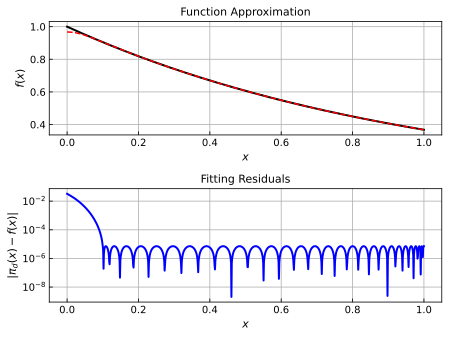

In [7]:

npts = 1000;      xvec = np.linspace(0.0,1.0,npts)

BAPx, fx, err = Fit.eval_approx(xvec)

ph.ig_plot_fit(xvec,BAPx,fx,err)


Here we have plotted the function $f(x)$ as a solid black line, the polynomial $\pi_d(x)$ as a dashed red line, and the residues $r(x) \pi_d(x) - f(x)$ as a blue line.

Finally, we can access the convergence of the $L^\infty$ norm with respect to the number of Remez iterations.  This is helpful when debugging approximations for more complicated functions:

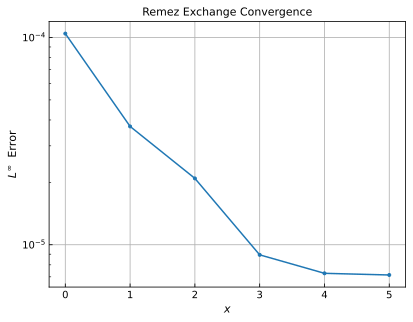

In [8]:

ph.ig_plot_convergence(Fit.conv_err_linf)


Finally, we can access the optimized set of fitting points if they are to be used later:

In [9]:
Fit.get_pts()

array([0.1       , 0.10858257, 0.1318926 , 0.16633179, 0.20661538,
       0.25048382, 0.29636623, 0.34358438, 0.3909446 , 0.43758819,
       0.4835601 , 0.52854691, 0.57241711, 0.61492987, 0.65576418,
       0.69486238, 0.73208108, 0.76728872, 0.80036427, 0.83119676,
       0.85968472, 0.88580359, 0.90932235, 0.93024429, 0.94850133,
       0.96432373, 0.97705486, 0.98715422, 0.99429926, 0.998583  ,
       1.        ])

<h3>3.2. Example: Hamiltonian Simulation (Trigonometric Functions)</h3>


Quantum signal processing was originally developed in the context of quantum (Hamiltonian) simulation, where our goal is to implement a propagator $\hat{U}(t) = \exp[-\imath \hat{H} t]$ that we can apply to some statevector $\vert\psi\rangle$ and get an evolved state $\vert \psi(t) \rangle = \hat{U}(t) \vert \psi \rangle$ (we assume that the Hamiltonian $\hat{H}$ is time-independent).  There is a 'canonical' procedure for implementing such an operator with QSP, where the exponential is decomposed according to Euler's identity $\exp (\imath \theta) = \cos \theta + \imath \sin \theta$ and a pair of controlled operations are used assemble the $\imath \sin \theta$ and $\cos \theta$ components conditioned on the $\vert + \rangle$ signal state.

Here, we show how the underlying polynomial expansions for trigonometric functions can be generated using the approximation methods in `Fitter`. We begin by defining the target functions and specifying the desired degree of approximation:

In [10]:

deg   = 30;      a  = 10.0;

f_cos  =  lambda x : mpm.cos(a*x)
f_sin  =  lambda x : mpm.sin(a*x)


We then create instances `p_cos` and `p_sin` of Fitter, which will hold the resulting Chebyshev polynomials.  Note that we must specify an even parity for `p_cos` and an odd parity for `p_sin`:

In [11]:

p_cos  = Fitter(f_cos, deg, parity=0)
p_sin  = Fitter(f_sin, deg, parity=1)


The next step is to invoke the `remez()` method to begin the approximation:

In [12]:

p_cos.remez();

p_sin.remez();



################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   1.3819889763967644e-40

REMEZ:		FITTING COMPLETE!

################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   2.2934337677513645e-41

REMEZ:		FITTING COMPLETE!



This process is very fast for either sine or cosine terms.  It is straightforward to verify the quality of fit for the cosine component:

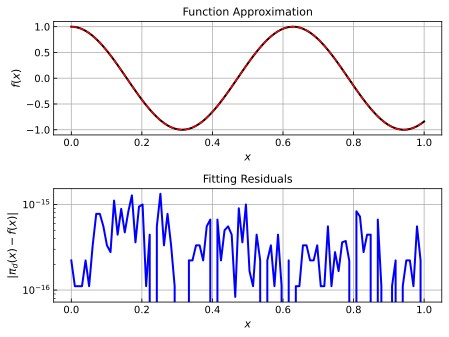

In [13]:

npts = 100;      xvec = np.linspace(0.0,1.0,npts)

p_cos_vals, f_cos_vals, err_cos = p_cos.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_cos_vals,f_cos_vals,err_cos)


As it is for the sine component:

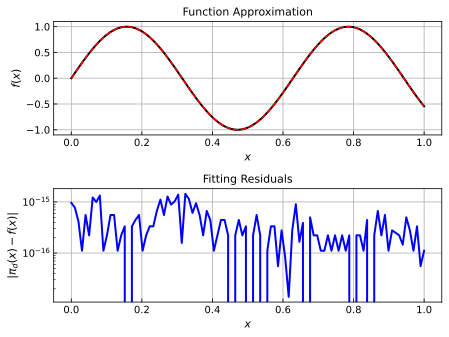

In [14]:


p_sin_vals, f_sin_vals, err_sin = p_sin.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_sin_vals,f_sin_vals,err_sin)


<h3>3.3. Example: Imaginary Time Evolution (Hyperbolic Functions)</h3>


The example from the previous section extends to hyperbolic functions, which can be used to implement quantum simulation in imaginary time.  In this case, we can encode the propagator using the relation $\exp(-\theta) = \cosh \theta - \sinh \theta$, though it is often more efficient to approximate $\exp(-\theta)$ directly (as we discuss below).

We begin by defining the hyperbolic sine and cosine, and normalize them so that their absolute sum on $[-1,1]$ never exceeds unity:

In [15]:

deg   = 30;      

Cn = mpm.cosh(1.0) + mpm.sinh(1.0)


f_cosh  =  lambda x : mpm.cosh(-x) / Cn
f_sinh  =  lambda x : mpm.sinh(-x) / Cn


Once again, we create  `Fitter` instances and invoke the `remez()` method:

In [16]:

p_cosh  = Fitter(f_cosh, deg, parity=0)
p_sinh  = Fitter(f_sinh, deg, parity=1)


In [17]:

p_cosh.remez()
p_sinh.remez() 


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   7.700887183829297e-101

REMEZ:		FITTING COMPLETE!

################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   1.2578356168450255e-102

REMEZ:		FITTING COMPLETE!



()

A cursory inspection of the data reveals a robust result: 

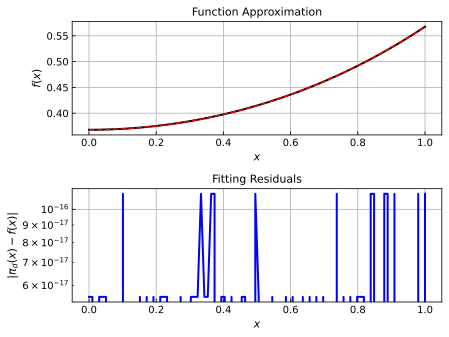

In [18]:

npts = 100;      xvec = np.linspace(0.0,1.0,npts)

p_cosh_vals, f_cosh_vals, err_cosh = p_cosh.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_cosh_vals,f_cosh_vals,err_cosh)


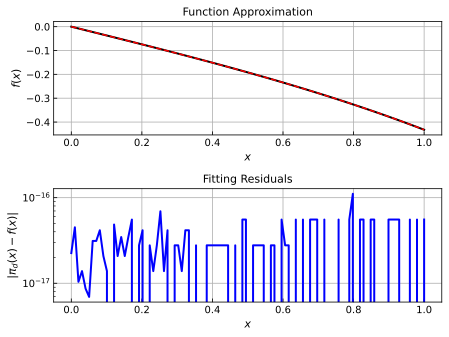

In [19]:

npts = 100;      xvec = np.linspace(0.0,1.0,npts)

p_sinh_vals, f_sinh_vals, err_sinh = p_sinh.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_sinh_vals,f_sinh_vals,err_sinh)


While the sum of these approximations gives the behavior expected for the exponential:



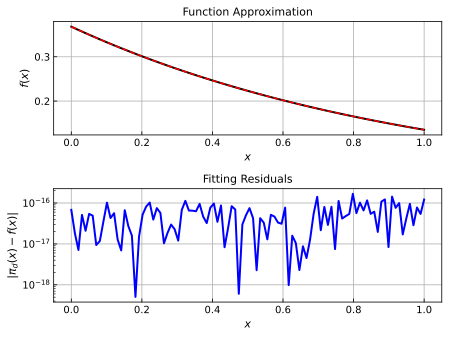

In [20]:

f_expdec_n  =  lambda x : mpm.exp(-x) / Cn 

f_expdec_n_vals = list(map(f_expdec_n, xvec))

p_expdec_sum_vals = p_sinh_vals + p_cosh_vals

ph.ig_plot_fit(xvec,p_expdec_sum_vals, f_expdec_n_vals,p_expdec_sum_vals - f_expdec_n_vals)


<h3>3.4. Example: Imaginary Time Evolution / Gibbs Sampling (Direct)</h3>


In contrast to the approach in section 3.2, we can directly fit $f(x) = \exp[-\beta \cdot x]$ as an even-parity function.  This circumvents the overhead associated with using separate QSP circuits to encode the even and odd parts of our target function.   We begin by defining the function and its parameters:

In [21]:

deg    = 40;    af     = 1.0;  

exp_ite  =  lambda x : mpm.exp(-af*np.abs(x))


After which we create a `Fitter` instance and run the Remez algorithm:

In [22]:

p_exp_ite  = Fitter(exp_ite, deg, parity=0)

p_exp_ite.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   0.007389894505858434
REMEZ		 Iter:  1 	  Linf_Err:   0.005937905624773276
REMEZ		 Iter:  2 	  Linf_Err:   0.00370552014479052
REMEZ		 Iter:  3 	  Linf_Err:   0.0035925715988270788
REMEZ		 Iter:  4 	  Linf_Err:   0.0035911596303879437

REMEZ:		FITTING COMPLETE!



This fit gives reasonably good (but not exceptional) agreement on the target domain:

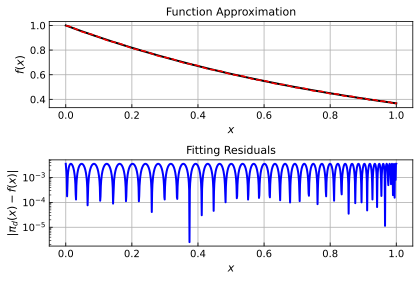

In [23]:

npts = 1000;      xvec = np.linspace(0.0,1.0,npts)

p_exp_ite_vals, f_exp_ite_vals, err_exp_ite = p_exp_ite.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_exp_ite_vals,f_exp_ite_vals,err_exp_ite)


Since `Fitter` performs a fit on the domain $D = [0, 1]$ by default, we can instead try restricting to $D' = [\kappa^{-1}, 1.0]$ by passing the `kappa = ` argument:

In [24]:

p_exp_ite  = Fitter(exp_ite, deg, parity=0, kappa = 10.0)

p_exp_ite.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   2.3061788549344797e-05
REMEZ		 Iter:  1 	  Linf_Err:   6.203420166117911e-06
REMEZ		 Iter:  2 	  Linf_Err:   3.145517756339769e-06
REMEZ		 Iter:  3 	  Linf_Err:   1.6100176126471158e-06
REMEZ		 Iter:  4 	  Linf_Err:   7.391023070749718e-07

REMEZ:		FITTING COMPLETE!



 While this fit performs poorly for $x \in [0,\kappa^{-1}]$, it is otherwise more robust:

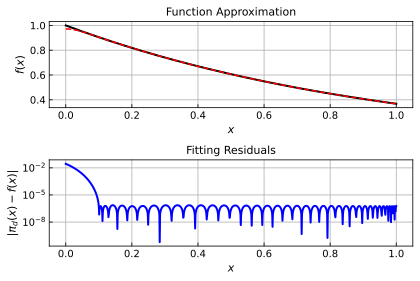

In [25]:

npts = 1000;      xvec = np.linspace(0.0,1.0,npts)

p_exp_ite_vals, f_exp_ite_vals, err_exp_ite = p_exp_ite.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_exp_ite_vals,f_exp_ite_vals,err_exp_ite)


The order of precedence used by `Fitter` in defining a domain (in terms of bounds and $\kappa$) is described at the end of this notebook.

<h3>3.5. Example: Matrix Pseudoinverse</h3>


The matrix pseudoinverse -- or Morse-Penrose inverse -- is central to several QSP-based linear system solvers.  In this context, we can devise a quantum approach to the linear system $\mathbf{A} \cdot \mathbf{x} = \mathbf{b}$ if we can encode $\mathbf{b}$ within the amplitudes of some statevector $| \psi_\mathbf{b} \rangle$ and $\mathbf{A}^{-1}$ within some operator $A$ acting on the state.

To see how this might be accomplished, assume that we have been given a matrix $\mathbf{A} \in \mathbb{R}^{m \times n}$  (or $ \mathbb{C}^{m \times n}$).  We  can then define a unique matrix $\mathbf{A}^+$ that acts as left inverse ($\mathbf{A}^+ \mathbf{A} = I$) when $\mathbf{A}$ has linearly independent columns and a right inverse ($\mathbf{A} \mathbf{A}^+ = I$) when it has linearly independent rows $^1$.  If we encode the function $f(x) = 1/x$ using a QSP sequence, it is possible to construct the pseudoinverse to an operator $A$ that stands in for $\mathbf{A}$ by generating $f(A^\dagger)$ using a QSP sequence (here $A^\dagger$ denotes the Hermitian adjoint).  The solution to our target linear system will then be encoded in the amplitudes of $| \psi_\mathbf{x} \rangle = f(A^{\dagger}) | \psi_\mathbf{b} \rangle$.



$^1$ This is uniquely determined if the matrix $A^+$ satisfies a set of rather rudimentary conditions [see R. Penrose, "A generalized inverse for matrices." Math. Proc. Camb. Philos. Soc., <b>51</b>, 406 (1955)].

<hr>

We encode the pseudoinverse encoding $f(x) = 1/(\kappa \cdot x)$ as in other examples, while taking care to adopt the domain $D = [\kappa^{-1},1.0]$:

In [21]:

deg    = 40;    kappa = 10.0 

f_pinv  =  lambda x : 1/(kappa*x)


Let's first try an even parity solution:

In [22]:

p_pinv  = Fitter(f_pinv, deg, parity=0, kappa = kappa)

p_pinv.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   0.0015849834202647359
REMEZ		 Iter:  1 	  Linf_Err:   0.000492642844331338
REMEZ		 Iter:  2 	  Linf_Err:   0.0002617385877512376
REMEZ		 Iter:  3 	  Linf_Err:   0.00013655352854975784
REMEZ		 Iter:  4 	  Linf_Err:   6.161001397147333e-05
REMEZ		 Iter:  5 	  Linf_Err:   5.297027243739698e-05
REMEZ		 Iter:  6 	  Linf_Err:   5.253629354061611e-05

REMEZ:		FITTING COMPLETE!



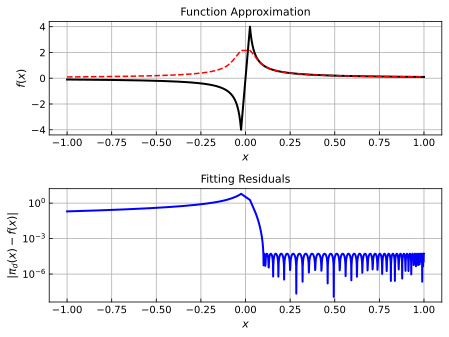

In [23]:

npts = 1000;     

xvec1 = np.linspace(-1.0,-1.0/(4.0*kappa),npts)
xvec2 = np.linspace(1.0/(4.0*kappa),1.0,npts)

xvec = np.concatenate((xvec1,xvec2))

p_pinv_vals, f_pinv_vals, err_pinv = p_pinv.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_pinv_vals,f_pinv_vals,err_pinv)


>And an odd-parity counterpart:

In [24]:

p_pinv_o  = Fitter(f_pinv, deg, parity=1, kappa = kappa)

p_pinv_o.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   0.0060402450746224025
REMEZ		 Iter:  1 	  Linf_Err:   0.0022063114494350108
REMEZ		 Iter:  2 	  Linf_Err:   0.0013005658652268917
REMEZ		 Iter:  3 	  Linf_Err:   0.0005515186516925815
REMEZ		 Iter:  4 	  Linf_Err:   0.0003765681097899501
REMEZ		 Iter:  5 	  Linf_Err:   0.0003594873872698128
REMEZ		 Iter:  6 	  Linf_Err:   0.00035922571292558973

REMEZ:		FITTING COMPLETE!



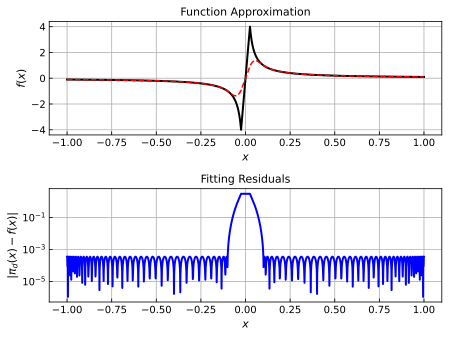

In [25]:

npts = 1000;      

xvec1 = np.linspace(-1.0,-1.0/(4.0*kappa),npts)
xvec2 = np.linspace(1.0/(4.0*kappa),1.0,npts)

xvec = np.concatenate((xvec1,xvec2))

p_pinv_o_vals, f_pinv_o_vals, err_pinv_o = p_pinv_o.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_pinv_o_vals,f_pinv_o_vals,err_pinv_o)


The desired implementation will clearly depend on the linear system of interest.

<h3>3.6. Example: Error Function</h3>


A useful primitive in QSP-based algorithms -- notably functions for eigenvalue estimation and thresholding --  is the scaled error function:

\begin{equation}
f(x) = c \cdot \text{erf}(ax) = \frac{2 c}{\sqrt{\pi}} \int_0^{a x} e^{-t^2} \, dt
\end{equation}

where $a, c \in \mathbb{R}$. 

This problem is quite straightforward, though it may be necessary to introduce and tune $\kappa$ for large values of $a$.  We set up the optimization problem as usual:

In [26]:

deg = 40;   sc = 1.0;    ac = 10.0;

f_erf = lambda x : sc*(mpm.erf(ac*x))


In [27]:

p_erf  = Fitter(f_erf, deg, parity=1)

p_erf.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   8.714948955095163e-09

REMEZ:		FITTING COMPLETE!



Convergence is rapid and robust:

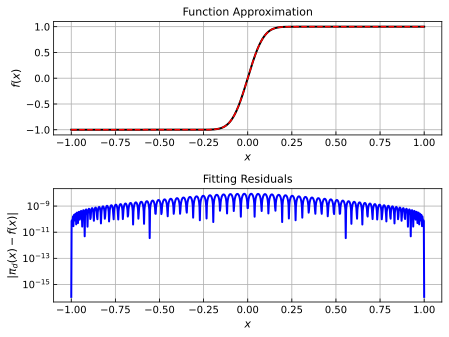

In [28]:

npts = 1000;     


xvec = np.linspace(-1.0,1.0,npts)

p_erf_vals, f_erf_vals, err_erf = p_erf.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_erf_vals,f_erf_vals,err_erf)

<h3>3.7. Example: Eigenvalue Threshold Function</h3>


The eigenvalue threshold function is derived from the error function and has been used in several quantum algorithms:

\begin{equation}
f(x) = -\frac{c}{2} \Big[\text{erf}\big(a(x + 0.5)\big) -  \text{erf}\big(a(x - 0.5)\big) \Big]
\end{equation}

In [29]:

deg = 30;   sc = 1.0;    ac = 10.0;

f_etf = lambda x : -0.5*sc*( mpm.erfc(a*(x + 0.5)) - mpm.erfc(a*(x - 0.5)) )


In [30]:

p_etf  = Fitter(f_etf, deg, parity=0)

p_etf.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   5.531536859875162e-07

REMEZ:		FITTING COMPLETE!



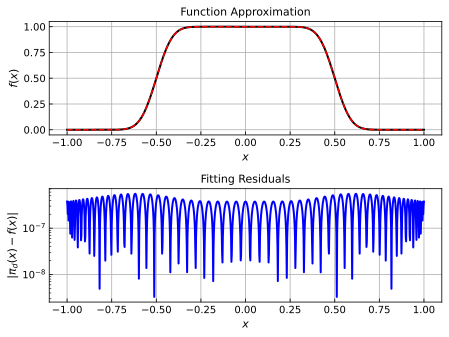

In [31]:

npts = 1000;     


xvec = np.linspace(-1.0,1.0,npts)

p_etf_vals, f_etf_vals, err_etf = p_etf.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_etf_vals,f_etf_vals,err_etf)

<h3>3.8. Example: Eigenvalue Filtering Function</h3>


\begin{equation}
f_k(x,\Delta_\lambda) = \frac{T_k \Big( 2 \frac{x^2 - \Delta^2_\lambda}{1 - \Delta^2_\lambda} -1 \Big)}{T_k \Big( -2 \frac{ \Delta^2_\lambda}{1 - \Delta^2_\lambda} -1 \Big)}
\end{equation}

In [32]:

deg  =  30;   delta  =  0.3

f_efilt_d = lambda x, k, D : chebyshev_m(-1.0 - 2.0*(D**2)/(1-(D**2)),k)
f_efilt_n = lambda x, k, D : chebyshev_m(-1.0 + 2.0*((x**2)-(D**2))/(1-(D**2)),k)

f_efilt   = lambda x : f_efilt_n(x,deg,delta) / f_efilt_d(x,deg,delta)


In [33]:

p_efilt  = Fitter(f_efilt, deg, parity=0)

p_efilt.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   2.913592813549187e-07

REMEZ:		FITTING COMPLETE!



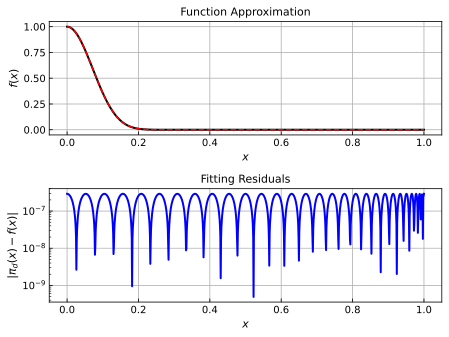

In [34]:

npts = 1000;     


#xvec = np.linspace(-1.0,1.0,npts)

xvec = np.linspace(0.0,1.0,npts)


p_efilt_vals, f_efilt_vals, err_efilt = p_efilt.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_efilt_vals,f_efilt_vals,err_efilt)

<h3>3.9. Example: Phase Estimation Polynomial</h3>


In [35]:

sqt = 1.0/mpm.sqrt(2.0);     sc = 1.0;    k = 10.0

 
f_phest = lambda x : sc * (mpm.erf(k*(sqt - x)) + mpm.erf(k*(sqt + x))) - 1


In [36]:

p_phest  = Fitter(f_phest, deg, parity=0)

p_phest.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   5.8425561164975845e-08

REMEZ:		FITTING COMPLETE!



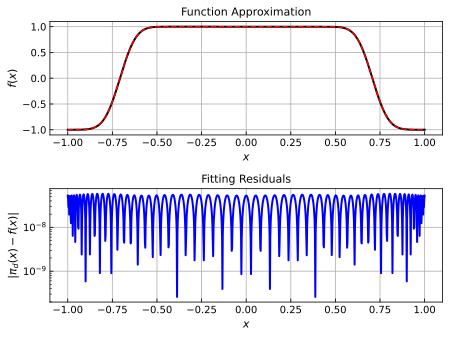

In [37]:

npts = 1000;     

xvec = np.linspace(-1.0,1.0,npts)

p_phest_vals, f_phest_vals, err_phest = p_phest.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_phest_vals,f_phest_vals,err_phest)


<h3>3.10. Example: Linear Amplification Function</h3>


\begin{equation} f_{k,\Gamma}(x) = \frac{x}{4 \Gamma} \Big[\text{erf}\big(k (x + 2\Gamma)\big) -  \text{erf}\big(k (x - 2\Gamma)\big) \Big]
\end{equation}

In [38]:

deg = 60;   G = 0.2;     k = 16.0
f_lamp = lambda x : (x/(4*G)) * (mpm.erf(k*(x + 2*G)) - mpm.erf(k*(x - 2*G))) 


In [39]:

p_lamp  = Fitter(f_lamp, deg, parity=1)

p_lamp.remez();


################################################################################
#    FITTER:REMEZ   ---   Approximation in a Chebyshev polynomial basis.       #
################################################################################ 

REMEZ		 Iter:  0 	  Linf_Err:   1.5644997235489852e-09
REMEZ:		REMEZ may have failed.  Check results.


REMEZ:		FITTING COMPLETE!



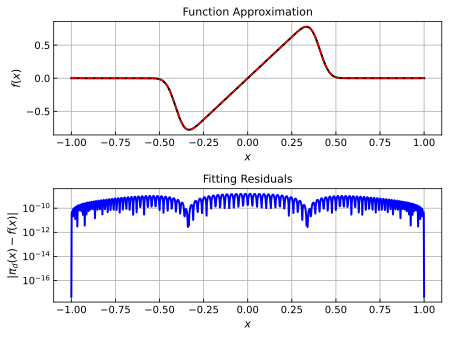

In [40]:

npts = 1000;     

xvec = np.linspace(-1.0,1.0,npts)

p_lamp_vals, f_lamp_vals, err_lamp = p_lamp.eval_approx(xvec)

ph.ig_plot_fit(xvec,p_lamp_vals,f_lamp_vals,err_lamp)
